<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification?scriptVersionId=130108723" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Work in progress 🚧

# Introduction

The RSNA-MICCAI Brain Tumor Radiogenomic Classification competition is a multi-class classification problem where the goal is to predict the subtype of brain tumor present in a given MRI scan based on radiomic features. 
f
There are three classes: 
- LGG (low-grade glioma)
- HGG (high-grade glioma) 
- WT (hemangioblastoma)

The dataset you will be working with consists of MRI scans from the National Cancer Institute (NCI) and The Cancer Imaging Archive (TCIA) datasets. The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

Here's the competition [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

# Contributors

- [David Goudard](https://www.kaggle.com/goudgoud)
- [Louis-Marie Renaud](https://www.kaggle.com/louismarierenaud)
- [Yannick Stephan](https://github.com/YanSteph)


# Dataset

The exact mpMRI scans included are:
- Fluid Attenuated Inversion Recovery (FLAIR)
    * What it is: These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * What it highlights: It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.
- T1-weighted pre-contrast (T1w)
    * What it is: These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * What it highlights: It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.
- T1-weighted post-contrast (T1Gd)
    * What it is: These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * What it highlights: It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.
- T2-weighted (T2)
    * What it is: These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * What it highlights: It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

# Necessary imports

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Print indent
import json

import torch # use to load mateuszbuda/brain-segmentation-pytorch pre-entrained model

# image dicom reader
import pydicom
from pydicom import dcmread 

import SimpleITK as sitk # image filtering
from PIL import Image #  PIL is an Python library used for image processing

# sklearn
from sklearn.model_selection import train_test_split

!pip install pyradiomics > /dev/null

import radiomics

warnings.filterwarnings('ignore')

# Reading Data

In [27]:
path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

train_path = path + "train/"
train_label_file = path + '/train_labels.csv'

# Dataset of the project, explanation in next section.
dataset = pd.read_csv(train_label_file)
samp_subm = pd.read_csv(path + 'sample_submission.csv')

# Dataset structure exploration

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

ℹ️ **Note:** However, report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709].

In [28]:
print('Samples of train folder:', len(dataset))

Samples of train folder: 585


In [29]:
dataset.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


The "train_labels.csv" file.

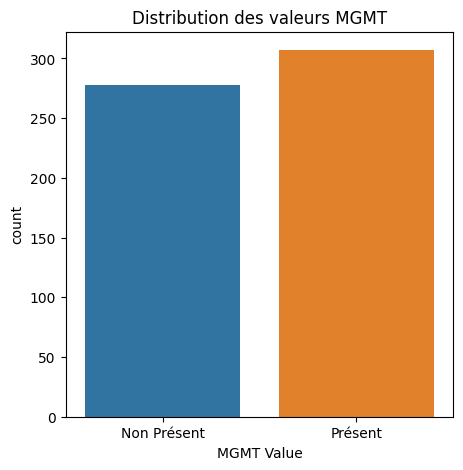

In [30]:
plt.figure(figsize=(5, 5))
sns.countplot(data=dataset, x="MGMT_value")
plt.title("Distribution des valeurs MGMT")
plt.xlabel("MGMT Value")
plt.xticks([0, 1], ["Non Présent", "Présent"])
plt.show()

The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT promoter methylation for each subject in the test data.

ℹ️ **Note:** We deduce that we have to separate the sets of given train into part two part train and test for training.

In [31]:
samp_subm.head(1)

,BraTS21ID,MGMT_value
0,1,0.5


### Folders content

In [32]:
# Extract first train sample
first_folder = str(dataset.loc[0, 'BraTS21ID']).zfill(5) + "/"

# Folders content
print(
    "Folders content for all patients:", 
        json.dumps(os.listdir(train_path + first_folder), indent=4)
)

Folders content for all patients: [
    "T2w",
    "T1wCE",
    "T1w",
    "FLAIR"
]


### First patient exploration

In the first Dataset of the patient, we will explore the images contained in ['T2w', 'T1wCE', 'T1w', 'FLAIR'] of the first patient.

In [33]:
print('Number of FLAIR images:', len(os.listdir(train_path + first_folder +'FLAIR')))
print('Number of T1w images:', len(os.listdir(train_path + first_folder + 'T1w')))
print('Number of T1wCE images:', len(os.listdir(train_path + first_folder + 'T1wCE')))
print('Number of T2w images:', len(os.listdir(train_path + first_folder + 'T2w')))

Number of FLAIR images: 400
Number of T1w images: 33
Number of T1wCE images: 129
Number of T2w images: 408


ℹ️ **Summary:** 
* Exclusion of data [00109, 00123, 00709].
* Exclusion of "/test" folder. 

In [34]:
# ---

<h1>Brain Tumor dataset generator from images</h1>
<hr/>

# TODO switch to englais add details of the logic why etc..

<h3>Cette partie va permettre de tenter d'obtenir la segmentation des tumeurs.

Segmentation sera obtenue avec Unet 

Unet https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

Features seront obtenus avec la classe radiomics.shape2D.RadiomicsShape2D

https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D<

In [35]:
# Skip brain segmentation with PyTorch UNet
skip_brain_segmentation_pytorch_unet = True

path = "../input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/"
dataset_path = "/kaggle/input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"
#path + "rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv/"



<h2>Initialisation</h2>
<hr/>


Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI

TODO EDIT

In [36]:
# Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI
segmentation_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True, trust_repo=False)


The repository mateuszbuda_brain-segmentation-pytorch does not belong to the list of trusted repositories and as such cannot be downloaded. Do you trust this repository and wish to add it to the trusted list of repositories (y/N)? y


The repository is already trusted.


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [37]:
# définit le "reader"
# Read serie of image files into a SimpleTK image
sitk_reader = sitk.ImageSeriesReader()
sitk_reader.LoadPrivateTagsOn()

<h2>Définition des fonctions</h2>
<hr/>

In [38]:
# Définition de la fonction principale de récupération des images de chaque patient et regroupement pour segmentation
# Elle sera appelée sur l'ensemble des patients du dataset train
def get_processed_image(BraTS21ID):
    '''
    definition de la fonction de récupération des images de chaque patient et regroupement pour segmentation
    in : BraTS21ID id du patient
    out : image constituée des différentes images du patient
    '''
    # LE MODELE DE SEGMENTATION LIMITE A 3 COUCHES
    # IMPASSE SUR T2W
    
    # chemin des sequences d'images
    t1w_path = f'{train_path}/{str(BraTS21ID).zfill(5)}/T1w'
    flair_path = f'{train_path}/{str(BraTS21ID).zfill(5)}/FLAIR'
    t1wce_path = f'{train_path}/{str(BraTS21ID).zfill(5)}/T1wCE'
    #t2w_path = f'{train_path}/{str(BraTS21ID).zfill(5)}/T2w'

    # GetGDCMSeriesFileNames : 
    # ----------------------
    #Generate a sequence of filenames from a directory with a DICOM data set and a series ID. 
    #This method generates a sequence of filenames whose filenames point to DICOM files. 
    #The data set may contain multiple series. 
    
    t1w_image = sequence_filenames(t1w_path)
    flair_image = sequence_filenames(flair_path)
    t1wce_image = sequence_filenames(t1wce_path)
    #t2w_image = sequence_filenames(t2w_path)
            
    # re-sampling
    re_sampled_flair = re_sample_image(flair_image, t1w_image)
    re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
    #re_sampled_t2w = re_sample_image(t2w_image, t1w_image)

    # normalisation
    t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
    flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
    t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
    #t2w_array = normalize(sitk.GetArrayFromImage(re_sampled_t2w))

    sequence_stacked = np.stack([t1w_array, flair_array, t1wce_array]) #, t2w_array])

    central_slice = t1w_array.shape[0] // 2
    rvb = sequence_stacked[:, central_slice, :, :].transpose(1, 2, 0)
    image = Image.fromarray((rvb * 255).astype(np.uint8))
    return  np.array([np.moveaxis(np.array(image.resize((256, 256))), -1, 0)])

# Fonction retournant une séquence d'images pour un dossier donné
def sequence_filenames(path) :
    '''
    # GetGDCMSeriesFileNames : 
    # ----------------------
    #Generate a sequence of filenames from a directory with a DICOM data set and a series ID. 
    #This method generates a sequence of filenames whose filenames point to DICOM files. 
    #The data set may contain multiple series. 
    in : path le chemin des fichiers
    out : la série
    '''
    filenames = sitk_reader.GetGDCMSeriesFileNames(path)
    sitk_reader.SetFileNames(filenames)
    image = sitk_reader.Execute()
    
    return image    

#Fonction de normalisation des données obtenues à partir des images
#Est-ce pertinent ?
def normalize(dataset) :
    return (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))

# Fonction de ré-echantillonnage des images entre elles
def re_sample_image(image, ref_img):
    '''
    definition de la fonction de récupération des images de chaque patient et regroupement pour segmentation
    in : BraTS21ID id du patient
    out : image constituée des différentes images du patient
    '''
    re_sampler = sitk.ResampleImageFilter()
    
    re_sampler.SetReferenceImage(ref_img)

    re_sampler.SetDefaultPixelValue(image.GetPixelIDValue())
    re_sampler.SetInterpolator(sitk.sitkLinear)
    re_sampler.SetOutputSpacing(ref_img.GetSpacing())
    re_sampler.SetOutputDirection(ref_img.GetDirection())
    re_sampler.SetOutputOrigin(ref_img.GetOrigin())
    re_sampler.SetSize(ref_img.GetSize())
    re_sampler.SetTransform(sitk.AffineTransform(image.GetDimension()))

    re_sampled_image = re_sampler.Execute(image)
    
    return re_sampled_image

# Fonction d'obtention de l'image segmentée
def segmentation_process(image_resized):
    '''
    in : re_sampled_image
    out : segmented image
    '''
    #img_src = np.array([np.moveaxis(np.array(re_sampled_image.resize((256, 256))), -1, 0)])
    segmentation = segmentation_model(torch.Tensor(image_resized))
    return segmentation

#Fonction d'affichage en ligne des images sources ré-échantillonées et l'image de segmentation
def show_segmentation(img_src,segmentation) :
    '''
    in : img_src is re_sampled_image resized, segmentation is the result of segmentation_model application
    '''
    titles=['T1w','FLAIR','T1wce'] #,'T2w']
    for i in range(3):
        plt.subplot(1,4,1+i)
        plt.imshow(img_src[0, i])
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
    
    plt.subplot(1,4,4)
    plt.imshow(segmentation.detach().numpy()[0,0])
    plt.title('Segmentation')
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.show()
    
# Fonction de définition des structures des DataFrames des données des images
# DataFrame
def init_dataset_radiomics() :
    '''
    Création à vide des dataset d'acquisition des données Radiomics
    '''
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    df_shapes_columns = ['ID','BraTS21ID','MeshSurface','PixelSurface','Perimeter','PerimeterSurfaceRatio','Sphericity',
                              'SphericalDisproportion','MaximumDiameter','MajorAxisLength','MinorAxisLenth','Elongation']
    df_shapes = pd.DataFrame(columns=df_shapes_columns) 


    df_textures_columns = ['ID','Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
    df_textures = pd.DataFrame(columns=df_textures_columns) 


    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    df_first_orders_features = pd.DataFrame(columns=df_first_orders_features_columns) 
    
#Fonction d'ajout des données des images du patient spécifié aux dataframes

def add_patient_data(ID,img_resized,segmentation) :
    '''
    Ajoute des données tirées des images pour le dataset d'analyse
    in : ID (patient), img_resized,segmentation
    '''
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape2D.RadiomicsShape2D(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )
    
    shape2D = {}
    shape2D['ID'] = int(ID)
    shape2D['BraTS21ID'] = int(ID)
    shape2D['MeshSurface'] = results.getMeshSurfaceFeatureValue()
    shape2D['PixelSurface'] = results.getPixelSurfaceFeatureValue()
    shape2D['Perimeter'] = results.getPerimeterFeatureValue()
    shape2D['PerimeterSurfaceRatio'] = results.getPerimeterSurfaceRatioFeatureValue()
    shape2D['Sphericity'] = results.getSphericityFeatureValue()
    shape2D['SphericalDisproportion'] = results.getSphericalDisproportionFeatureValue()
    shape2D['MaximumDiameter'] = results.getMaximumDiameterFeatureValue()
    shape2D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape2D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape2D['Elongation'] = results.getElongationFeatureValue()
    
    df_shapes=df_shapes.append(shape2D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    #print(res)
    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    #print(res)
    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)

### Phase d'éxécution de création du dataset

Tous les patients du fichiers train_labels.csv seront utilisés


In [39]:
if skip_brain_segmentation_pytorch_unet == False:
    # Création à vide des datasets
    init_dataset_radiomics()
    # Charge le fichier des résultats avec les ID patients (jeu d'entrainement qui va nous servir sur l'ensemble)
    labels = dataset


    for i in labels.BraTS21ID :
        print(i)
        img_resized = get_processed_image(i)
        segmentation = segmentation_process(img_resized)
    
        add_patient_data(i,img_resized,segmentation)

    # jointure des 3 datasets
    df_shapes=df_shapes.set_index('ID')
    df_textures=df_textures.set_index('ID')
    df_first_orders_features=df_first_orders_features.set_index('ID')

    df = df_shapes
    df = df.join(df_textures)
    df = df.join(df_first_orders_features)

    df['BraTS21ID']=df['BraTS21ID'].astype(int)

    print(df.dtypes)
    print(df.head())

    # Enregistre le dataset obtenu
    df.to_csv('brain_tumor_dataset.csv', index = True) 
    
else:
    dataset = pd.read_csv(dataset_path)
    
print("Dataset loaded ✅")

Dataset loaded ✅


# Dataset exploration

In [51]:
dataset.head()

,ID,BraTS21ID,MeshSurface,PixelSurface,Perimeter,PerimeterSurfaceRatio,Sphericity,SphericalDisproportion,MaximumDiameter,MajorAxisLength,...,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
0,0.0,0,1970.0,1971.0,275.663997,0.139931,0.570766,1.752032,68.154237,63.790882,...,119.485033,118.0,78.0,83.0,6.540893,120.115163,0.155141,28436903.0,0.520692,150.979355
1,2.0,2,1393.0,1394.0,263.178716,0.188929,0.502724,1.989163,92.357999,61.123174,...,99.626973,100.0,46.0,70.0,4.442733,100.049199,-1.587057,13953720.0,0.474834,84.308483
2,3.0,3,551.0,590.0,733.636652,1.331464,0.113423,8.816583,236.027541,188.061185,...,53.510169,62.0,0.0,83.0,8.505129,57.416070,-1.655216,1944997.0,0.572094,433.266846
3,5.0,5,1538.0,1539.0,219.480231,0.142705,0.633414,1.578746,63.387696,60.362349,...,84.152047,84.0,62.0,52.0,5.957969,84.811008,-0.092428,11069884.0,0.586132,111.340105
4,6.0,6,3355.0,3356.0,289.279221,0.086223,0.709797,1.408854,76.941536,68.276939,...,159.935638,159.0,108.0,95.0,6.961388,160.451462,0.247894,86399118.0,0.503509,165.263438


In [69]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           585 non-null    float64
 1   BraTS21ID                    585 non-null    int64  
 2   MeshSurface                  585 non-null    float64
 3   PixelSurface                 585 non-null    float64
 4   Perimeter                    585 non-null    float64
 5   PerimeterSurfaceRatio        585 non-null    float64
 6   Sphericity                   585 non-null    float64
 7   SphericalDisproportion       585 non-null    float64
 8   MaximumDiameter              585 non-null    float64
 9   MajorAxisLength              585 non-null    float64
 10  MinorAxisLenth               585 non-null    float64
 11  Elongation                   585 non-null    float64
 12  Autocorrelation              585 non-null    float64
 13  ClusterProminence   

ℹ️ Note:
- non-null values

# First patient TODO USE DATA GENERATE

In [84]:
premiere_ligne = dataset.iloc[:1]

# Convertir la première ligne en dictionnaire
premiere_ligne_dict = premiere_ligne.to_dict(orient="records")[0]

# Formater l'affichage des colonnes et valeurs
affichage_formate = "\n".join([f"{colonne}: {valeur}" for colonne, valeur in premiere_ligne_dict.items()])

# Afficher toutes les colonnes et valeurs
print(affichage_formate)

ID: 0.0
BraTS21ID: 0
MeshSurface: 1970.0
PixelSurface: 1971.0
Perimeter: 275.6639969244296
PerimeterSurfaceRatio: 0.1399309629058018
Sphericity: 0.5707658706605531
SphericalDisproportion: 1.7520318775239485
MaximumDiameter: 68.15423684555495
MajorAxisLength: 63.79088163718111
MinorAxisLenth: 47.456974950621714
Elongation: 0.7439460583181684
Autocorrelation: 5.330686111440979
ClusterProminence: 3.1299014101848663
ClusterShade: 0.2949656947477074
ClusterTendency: 1.0175351255387302
Contrast: 0.1202920106904142
Correlation: 0.7883651276364155
DifferenceAverage: 0.1189478685851452
DifferenceEntropy: 0.5284288881583875
DifferenceVariance: 0.1058857532277353
Id: 0.940750089391639
Idm: 0.9406604799179544
Idmn: 0.992947719525951
Idn: 0.9762552310198132
Imc1: -0.5102102978917968
Imc2: 0.8276705311619313
InverseVariance: 0.1177717442430348
JointAverage: 2.2597279037453197
JointEnergy: 0.4317424864046278
JointEntropy: 1.6961912652982036
MCC: 0.8181913824750047
MaximumProbability: 0.60665024440944

ℹ️
- ID et BraTS21ID sont de même

In [67]:
#init_dataset_radiomics()
#img_resized = get_processed_image(0)
#segmentation = segmentation_process(img_resized)
#show_segmentation(img_resized,segmentation)
#add_patient_data(0,img_resized,segmentation)
#print(df_shapes.head()) 
#print(df_textures.head())
#print(df_first_orders_features.head())

# todo add targe into dateset

# Analysis

In [66]:
#TODO organisation idea

ImageSeriesReader (0x5ad5f881c3d0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



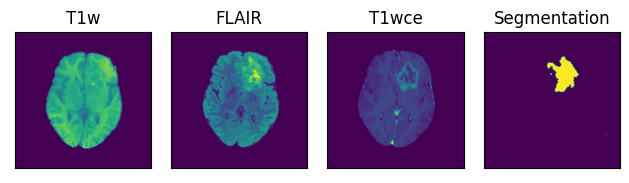

In [59]:
img_resized = get_processed_image(0)
segmentation = segmentation_process(img_resized)
show_segmentation(img_resized,segmentation)

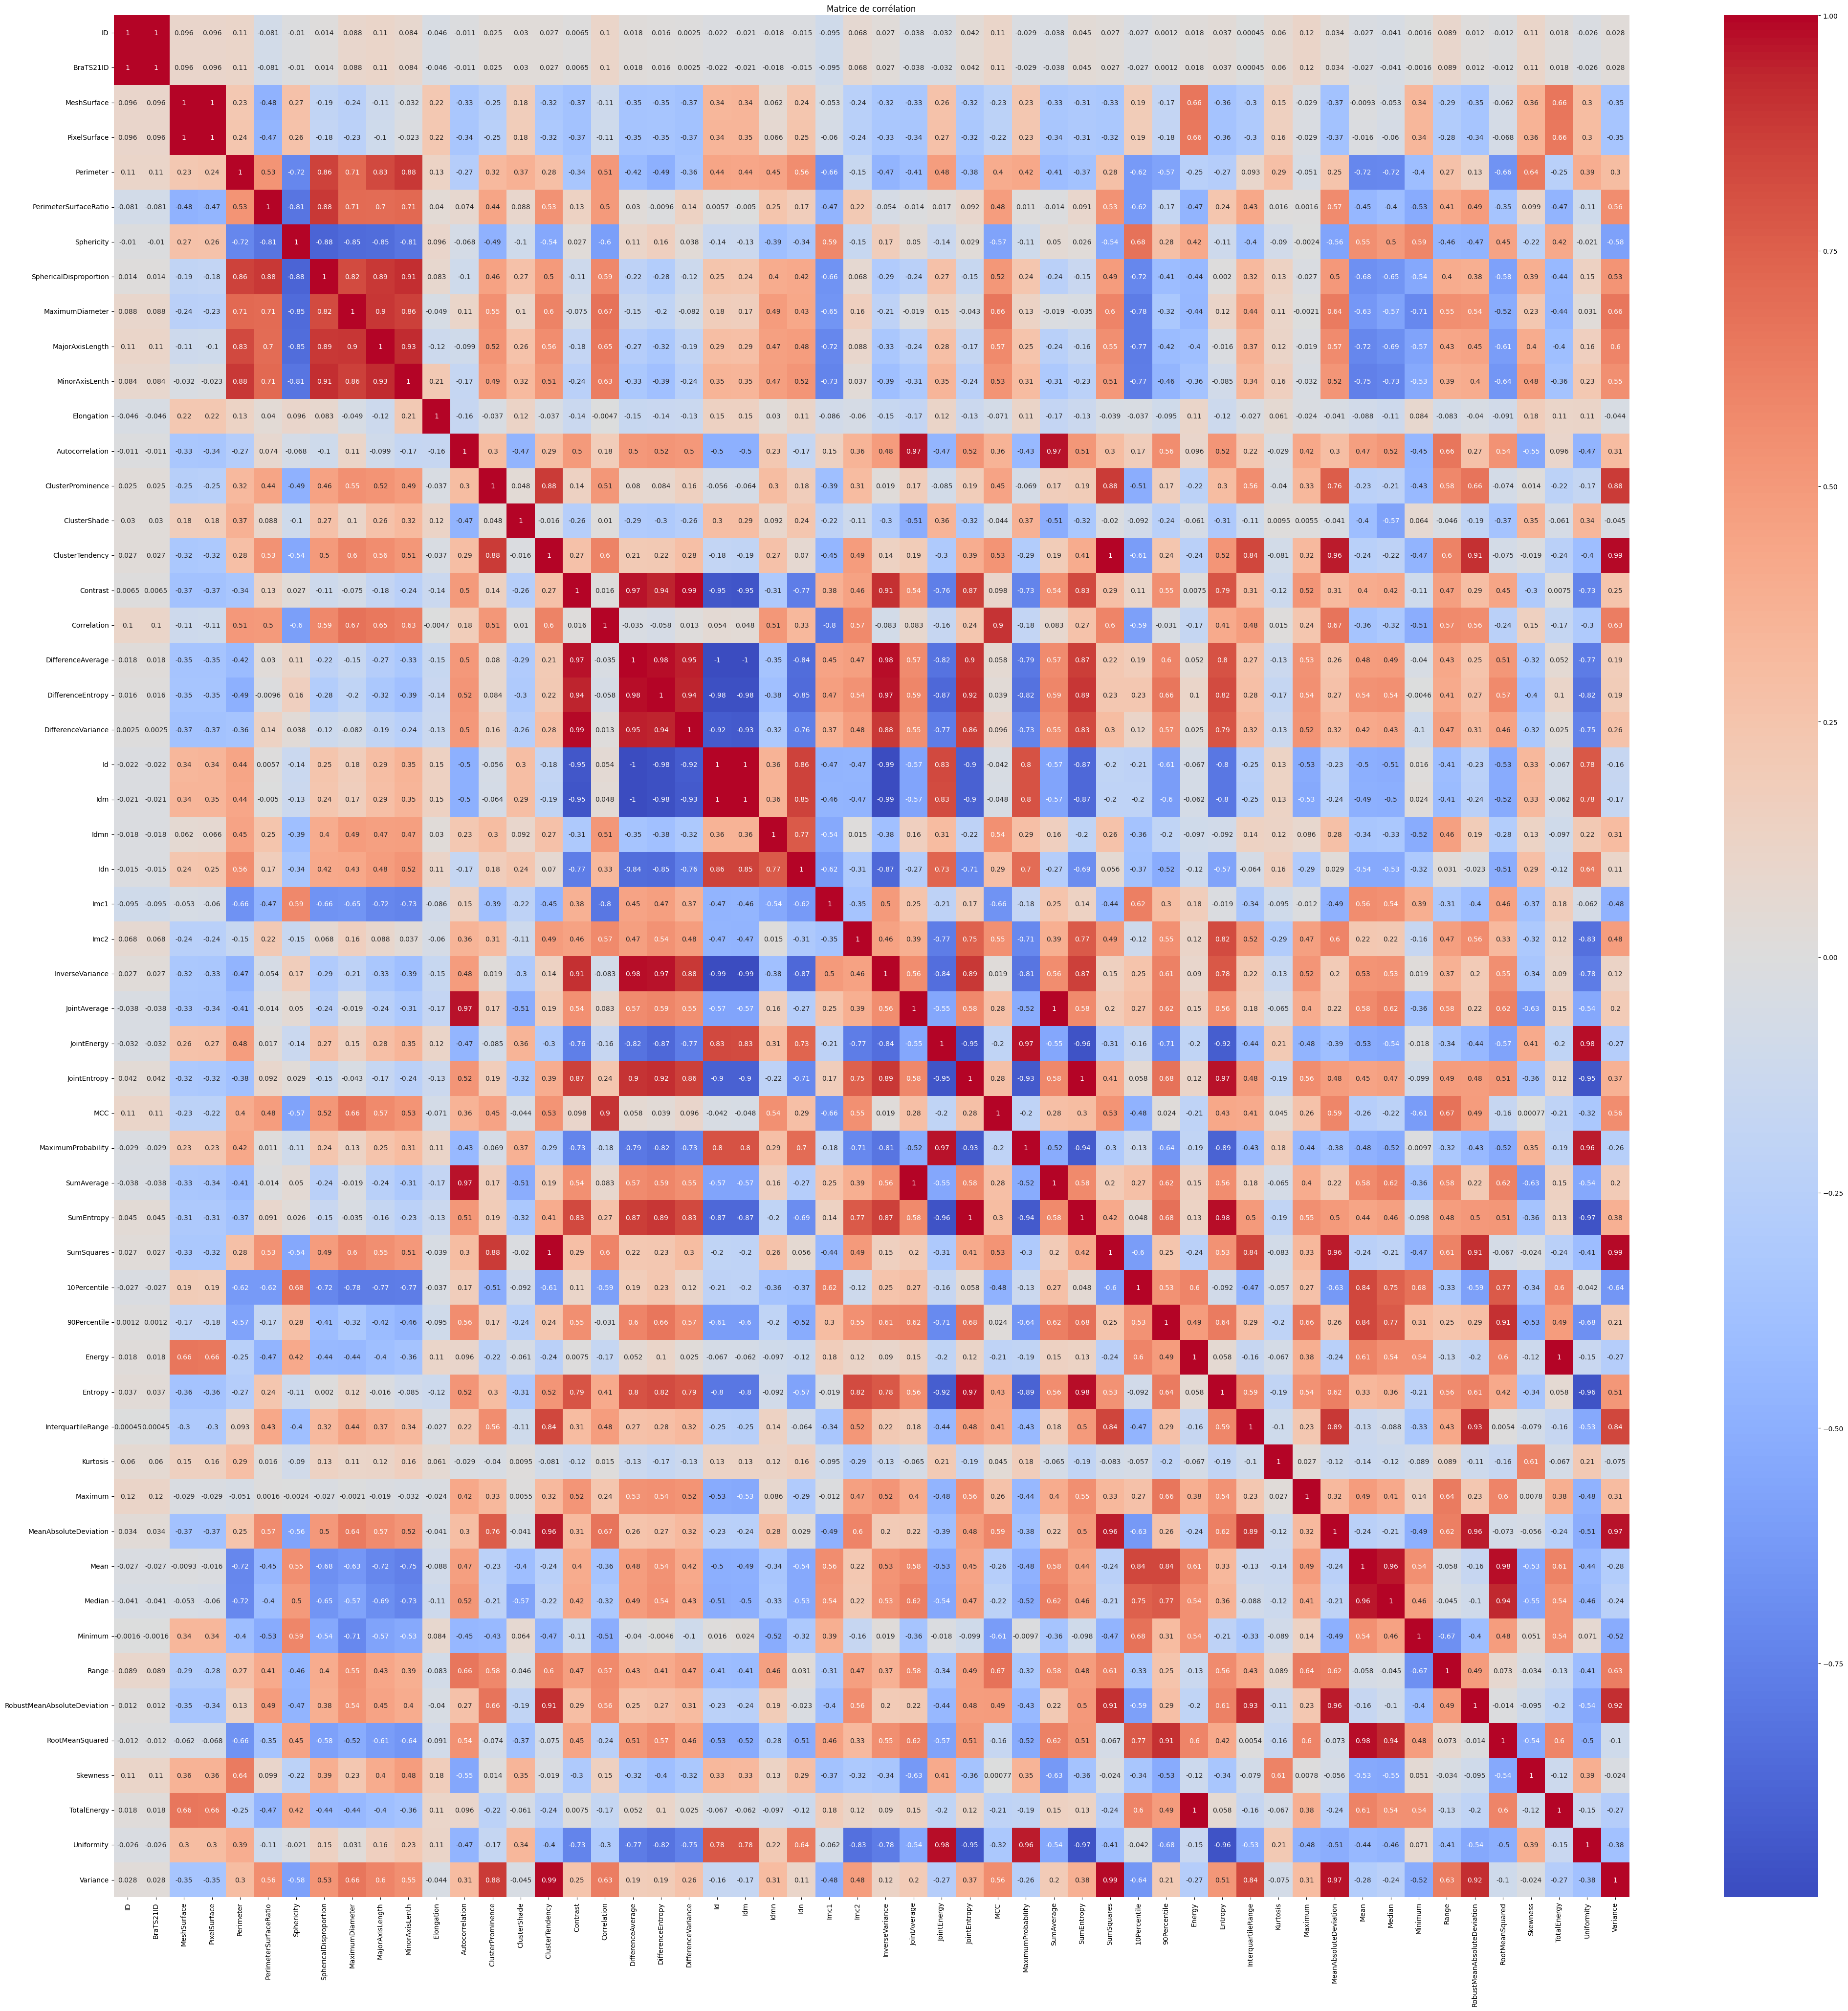

In [71]:
# Charger le jeu de données à partir d'un fichier CSV


# Calculer la matrice de corrélation
correlation_matrix = dataset.corr()

# Afficher la matrice de corrélation


plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

In [72]:
data = dataset
colonnes_similaires = []

# Parcourir chaque paire de colonnes
for i in range(len(data.columns)):
    for j in range(i + 1, len(data.columns)):
        # Vérifier si les valeurs des colonnes sont identiques
        if data.iloc[:, i].equals(data.iloc[:, j]):
            # Ajouter la paire de colonnes à la liste
            colonnes_similaires.append((data.columns[i], data.columns[j]))

# Afficher les colonnes ayant les mêmes valeurs
for colonne1, colonne2 in colonnes_similaires:
    print(f"Les colonnes {colonne1} et {colonne2} ont les mêmes valeurs.")

Les colonnes Energy et TotalEnergy ont les mêmes valeurs.
